# Reservoir computing clásico y cuántico en EEG reales.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
import pandas as pd
import random
import mne

## Carga y preprocesado de los datos.

In [ ]:
# Carga de datos.
eeg_young = np.load("./data/data/dataset_Younger.npy")
eeg_old = np.load("./data/data/dataset_Older.npy")

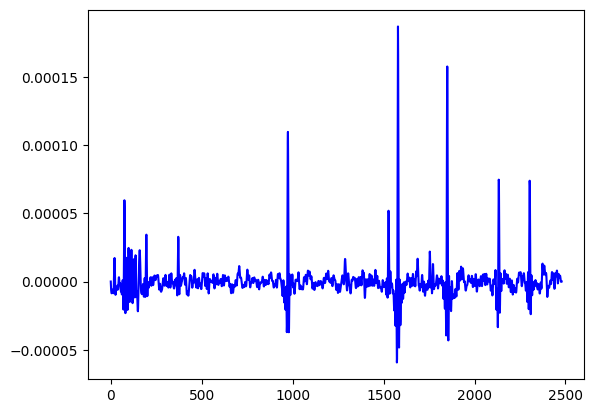

In [3]:
# Cogemos la señal de un canal de un sujeto joven.
muestra = eeg_young[0,:,:]

plt.plot(range(muestra.shape[0]), muestra[:,0], color = 'blue')
plt.show()

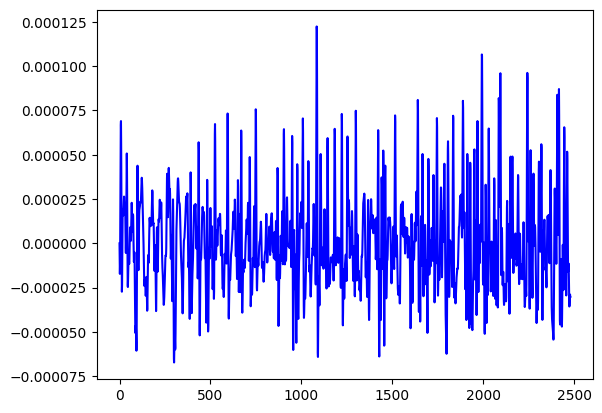

In [5]:
# EEG del sujeto 2.
sujeto2 = eeg_young[1,:,:]

plt.plot(range(sujeto2.shape[0]), sujeto2[:,0], color = 'blue')
plt.show()

In [4]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [5]:
# frecuencia baja = 0.1 Hz, frecuencia alta = 30 Hz y frecuencia de muestreo = 512 Hz
muestra_filt = bandpass_filter(muestra, lowcut = 0.1, highcut = 30, fs = 512)

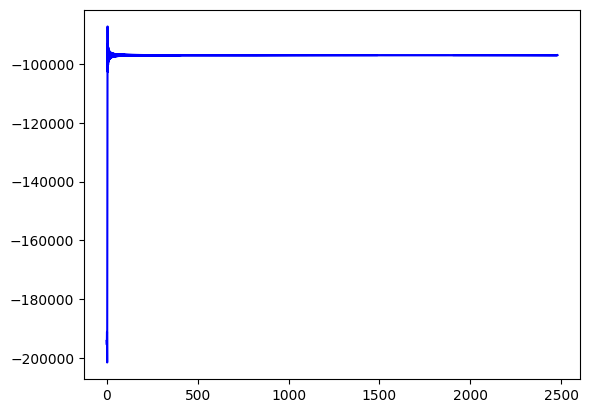

In [6]:
plt.plot(range(muestra_filt.shape[0]), muestra_filt[:,0], color = 'blue')
plt.show()

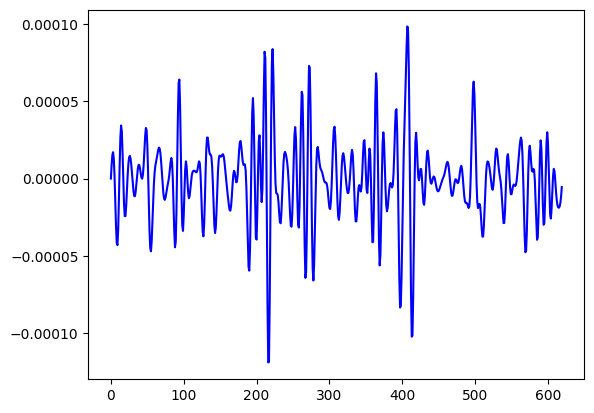

In [14]:
# Cogemos el EEG de un sujeto mayor.
muestra_adult = eeg_old[0,:,:]

plt.plot(range(muestra_adult.shape[0]), muestra_adult[:,0], color = 'blue')
plt.show()

In [8]:
# frecuencia baja = 0.1 Hz, frecuencia alta = 30 Hz y frecuencia de muestreo = 512 Hz
muestra_filt_adult = bandpass_filter(muestra_adult, lowcut = 0.1, highcut = 30, fs = 512)

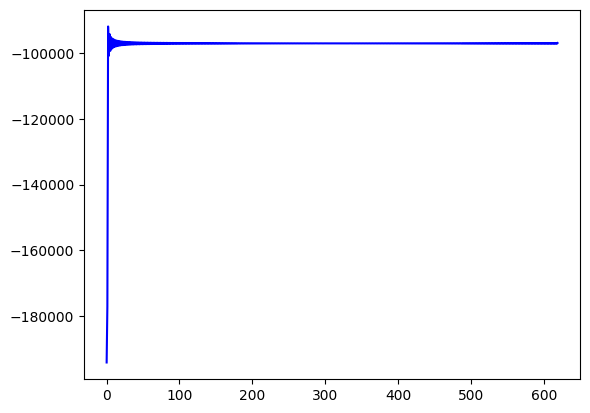

In [9]:
plt.plot(range(muestra_filt_adult.shape[0]), muestra_filt_adult[:,0], color = 'blue')
plt.show()

## RC clásico en Sujeto 2.

In [20]:
# Implementación reservoir clásico con un sujeto joven.

# Parámetros
num_input_channels = 65     # Dimensionalidad de entrada (65 canales)
num_reservoir_neurons = 80   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sujeto2[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS_clasico_joven2 = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)
print(RS_clasico_joven2.shape)
analytic_signal = hilbert(RS_clasico_joven2)
amplitude_envelope_clasico_joven2 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS_clasico_joven2.shape)
print(amplitude_envelope_clasico_joven2.shape)

(80, 2481)
(80, 2481)
(80, 2481)
(80, 2481)


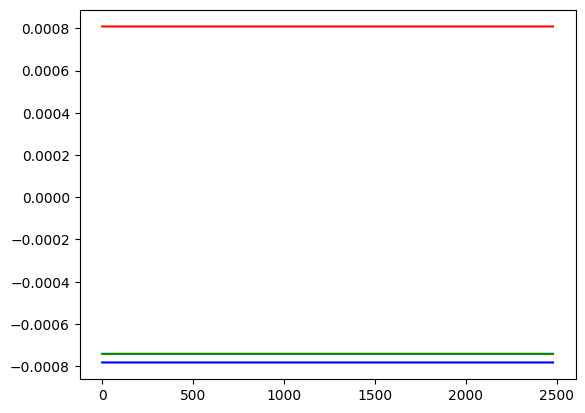

In [21]:
plt.plot(range(sujeto2.shape[0]), RS_clasico_joven2[0, 1:], color = 'green')
plt.plot(range(sujeto2.shape[0]), RS_clasico_joven2[1, 1:], color = 'red')
plt.plot(range(sujeto2.shape[0]), RS_clasico_joven2[2, 1:], color = 'blue')
plt.show()

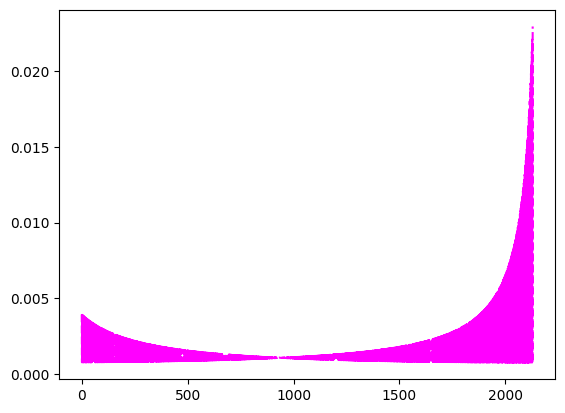

In [22]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_clasico_joven2.shape[1])
input_sequence_clasico_joven2 = amplitude_envelope_clasico_joven2[:, stable_start:-50]
plt.plot(input_sequence_clasico_joven2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [23]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_clasico_joven2.T)

# Resultados
idx_clasico_joven2 = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_clasico_joven2.shape)

Centroides de los clústeres:
[[1.06039813e-03 1.15671757e-03 1.11901289e-03 6.46684327e-05
  5.07675877e-04 4.18461508e-04 2.15899681e-04 1.34599695e-03
  5.14788244e-04 4.35129875e-04 5.81922822e-04 5.90053744e-04
  6.56394282e-04 8.04819032e-05 2.86821603e-04 8.18948987e-05
  6.59807743e-04 6.81210060e-05 2.76065285e-04 1.07291814e-03
  1.29132517e-03 5.71957684e-04 6.35454968e-04 7.29666711e-04
  6.69831894e-04 1.10081234e-03 1.01574727e-03 5.79297281e-04
  1.74177563e-03 3.03041376e-04 1.40611278e-04 1.28624284e-03
  1.76532591e-03 8.33635548e-04 1.18989834e-04 2.00223498e-04
  4.16537348e-04 1.38197756e-03 5.85649387e-04 1.36031998e-03
  1.32879451e-03 5.41736686e-04 6.65245267e-04 7.23281447e-04
  5.02637770e-04 4.48765672e-05 1.21757572e-04 2.67469607e-04
  1.63969928e-03 6.79376717e-04 5.11656970e-04 3.18477250e-05
  4.00764934e-04 7.39234451e-04 5.29762123e-04 1.07562748e-04
  5.72712574e-04 9.03127434e-04 1.25245786e-03 1.41153600e-03
  1.37568192e-03 8.89999105e-04 4.9907384

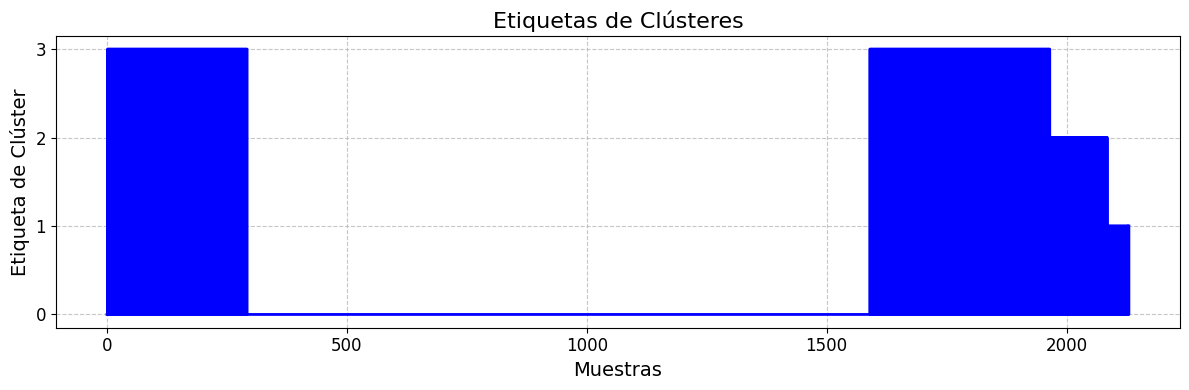

In [24]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_clasico_joven2.shape[1]), idx_clasico_joven2, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,400])
plt.tight_layout() 
plt.show()

## Implementación cuántica(sujeto menor).

### Versión adaptada a 2 qubits por canal.

In [10]:
# Definir parámetros principales
num_qubits = 2  # hacemos uso de 2 qubits
num_channels = 65  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits))  

In [11]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = muestra_filt
time_steps = input_series.shape[0]

shape_qubits = 4

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [0.47708926 0.3643236  0.0419002  0.05694242]
Step 1: [7.42223244e-01 4.03627976e-02 1.70476738e-04 4.03307275e-03]
Step 2: [0.01085237 0.14578304 0.65519283 0.05790945]
Step 3: [0.0016979  0.00062325 0.26165585 0.62293913]
Step 4: [0.44105885 0.41748794 0.03959664 0.04216718]
Step 5: [0.13794158 0.24715795 0.37373019 0.21273849]
Step 6: [0.23667044 0.55809424 0.09279458 0.03561755]
Step 7: [2.94324145e-04 1.16652994e-03 6.62558006e-01 1.98508728e-01]
Step 8: [0.70384788 0.07498562 0.00395299 0.04600225]
Step 9: [0.07181795 0.24366009 0.48304114 0.15128302]
Step 10: [0.47651669 0.00263006 0.00241709 0.44342409]
Step 11: [0.00250326 0.11792425 0.69668646 0.01818653]
Step 12: [0.35033216 0.06693006 0.08760164 0.44569937]
Step 13: [0.26119005 0.07834773 0.14738333 0.46654241]
Step 14: [0.54746938 0.36283176 0.00194731 0.00314915]
Step 15: [1.54544326e-07 2.31294745e-12 1.49660135e-05 7.61587806e-01]
Step 16: [0.00307026 0.43984543 0.47885582 0.00339196]
Step 17: [0.0220685  0.1697

In [12]:
outputs = outputs.T
outputs.shape

(4, 2480)

In [13]:
RS_cuantico_eeg = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg.shape)

(4, 2480)


In [14]:
analytic_signal = hilbert(RS_cuantico_eeg)
amplitude_envelope_eeg= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg.shape)

(4, 2480)
(4, 2480)


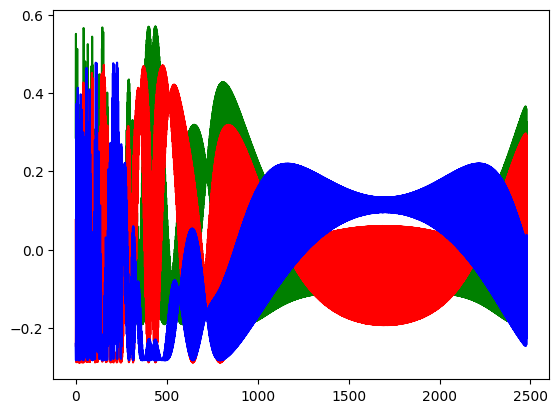

In [15]:
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg [0,:], color = 'green')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg [1,:], color = 'red')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg [2,:], color = 'blue')
plt.show()

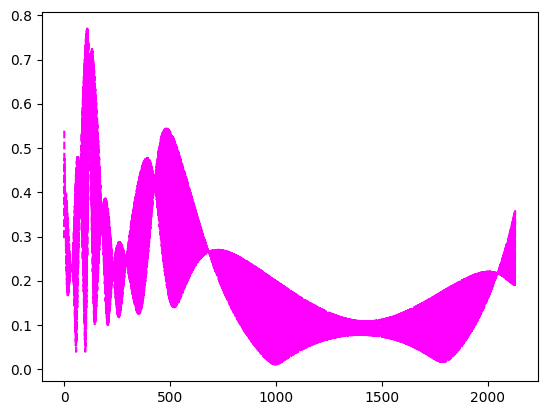

In [16]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg.shape[1])
input_sequence_cuant_eeg = amplitude_envelope_eeg[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [17]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.14843828 0.23563673 0.16192801 0.16525699]
 [0.41595184 0.43214236 0.27921613 0.22226609]
 [0.05010863 0.13303881 0.06958501 0.13365484]
 [0.24163125 0.14507413 0.2789883  0.0934779 ]]
(2130,)


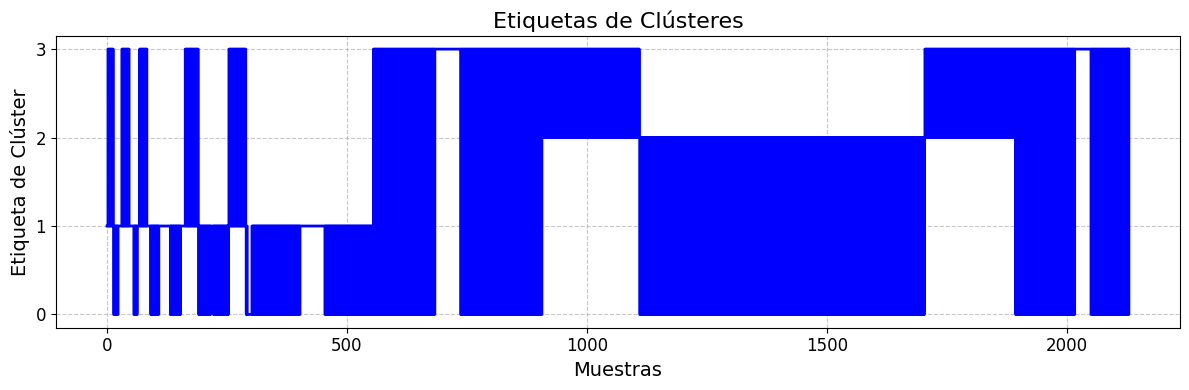

In [18]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,100])
plt.tight_layout() 
plt.show()

### Versión adaptada a 5 qubits por canal.

In [19]:
# Definir parámetros principales
num_qubits = 5  # hacemos uso de 5 qubits
num_channels = 65  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits))  

In [20]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = muestra_filt
time_steps = input_series.shape[0]

shape_qubits = 32

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [1.74113490e-01 1.57065982e-02 3.24421768e-04 3.63303874e-03
 1.00783350e-03 1.12858022e-02 4.97862682e-01 4.87587164e-02
 4.78395025e-07 5.35733240e-06 2.59391912e-04 2.31629838e-05
 8.34982752e-05 7.45616598e-06 1.53995390e-07 1.72452565e-06
 1.16990817e-07 1.31012795e-06 6.34339214e-05 5.66447445e-06
 2.04193834e-05 1.82339469e-06 3.76593516e-08 4.21730273e-07
 4.29909592e-02 3.84132305e-03 7.93368805e-05 8.88458087e-04
 2.46464315e-04 2.76003692e-03 1.32846239e-01 1.19327705e-02]
Step 1: [0.04114292 0.0217626  0.08239898 0.15493761 0.03435501 0.06490991
 0.01712976 0.00905776 0.01313758 0.02484346 0.00654888 0.00346266
 0.01573562 0.00832049 0.03156042 0.05963928 0.00910676 0.01722242
 0.00453948 0.0024002  0.01090782 0.00576752 0.0218803  0.04136526
 0.02852713 0.01508627 0.05718329 0.10784797 0.0238185  0.04502606
 0.01187432 0.0062786 ]
Step 2: [0.00735045 0.00701294 0.00068866 0.0007218  0.00135396 0.00141912
 0.01445085 0.01378736 0.01633868 0.0171249  0.17266379 0.164

In [21]:
outputs = outputs.T
outputs.shape

(32, 2480)

In [22]:
RS_cuantico_eeg_5 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_5.shape)

(32, 2480)


In [23]:
analytic_signal = hilbert(RS_cuantico_eeg_5)
amplitude_envelope_eeg_5= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_5.shape)

(32, 2480)
(32, 2480)


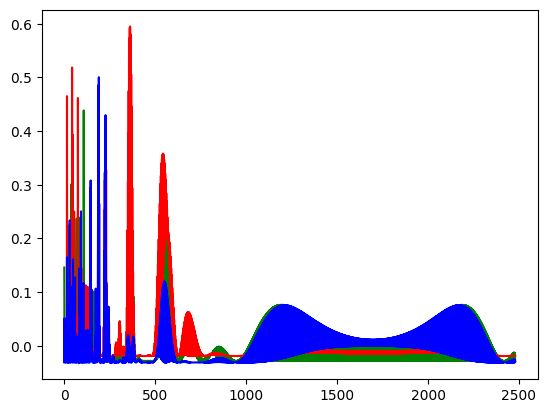

In [24]:
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_5 [0,:], color = 'green')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_5 [1,:], color = 'red')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_5 [2,:], color = 'blue')
plt.show()

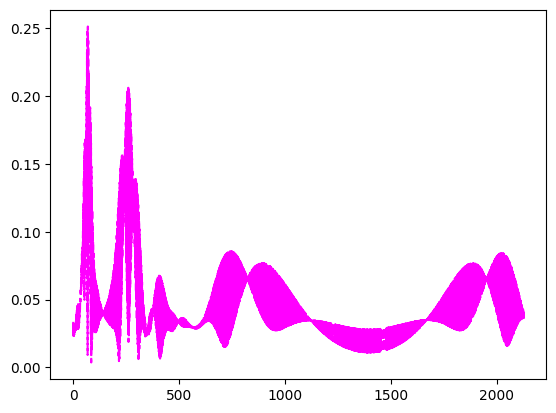

In [25]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg_5.shape[1])
input_sequence_cuant_eeg_5 = amplitude_envelope_eeg_5[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_5[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [26]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_5.T)

# Resultados
idx_5 = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_5.shape)

Centroides de los clústeres:
[[0.04101304 0.01618571 0.02766246 0.11391401 0.04150199 0.04709213
  0.05491708 0.02381834 0.08474899 0.05217995 0.03350344 0.01356743
  0.12107307 0.02766446 0.16380277 0.30201957 0.03286902 0.03848764
  0.03097688 0.01298124 0.01112771 0.0099349  0.02007756 0.013709
  0.04600589 0.03150585 0.01016925 0.02123601 0.0234855  0.04793556
  0.08722319 0.02591362]
 [0.04120491 0.01632034 0.04469415 0.06110254 0.03415443 0.05461236
  0.06069384 0.02082158 0.05657558 0.05517694 0.04391396 0.0148065
  0.06358408 0.04270013 0.48341574 0.15556068 0.03059752 0.03935144
  0.02894531 0.0145681  0.01406716 0.0101905  0.0161029  0.02031022
  0.03773826 0.02209985 0.01158759 0.03135876 0.02761541 0.05157898
  0.06215962 0.02062196]
 [0.03473619 0.0530385  0.03652333 0.05261023 0.0363127  0.0460557
  0.10238094 0.09581613 0.05462737 0.04768366 0.03036671 0.03826917
  0.05547266 0.04386299 0.19725263 0.1228721  0.03213232 0.04715436
  0.03422069 0.02470384 0.02189253 0.0253

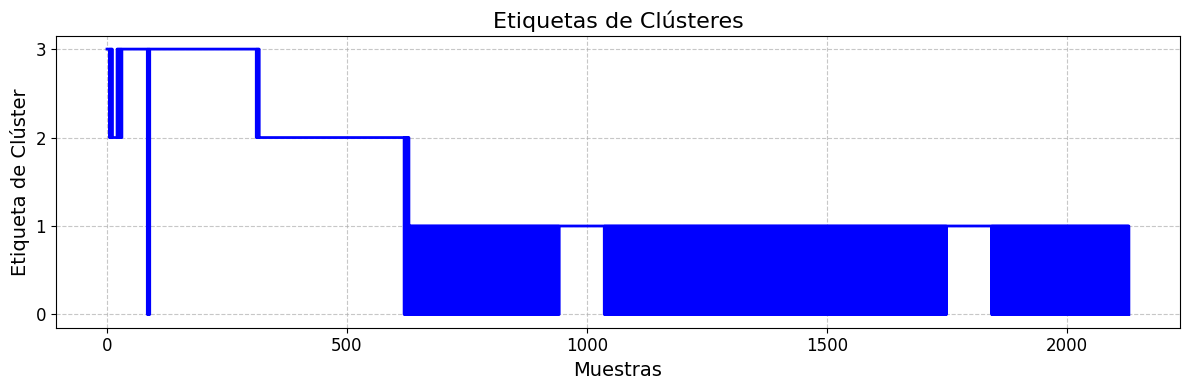

In [27]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_5.shape[1]), idx_5, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([1000,1100])
plt.tight_layout() 
plt.show()

### Versión adaptada a 10 qubits por canal.

In [28]:
# Definir parámetros principales
num_qubits = 10  # hacemos uso de 10 qubits
num_channels = 65  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits))

In [29]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = muestra_filt
time_steps = input_series.shape[0]

shape_qubits = 1024

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [3.34861873e-08 1.54197302e-08 2.67998442e-07 ... 3.97991438e-06
 6.91718230e-05 1.50216675e-04]
Step 1: [2.76894312e-07 5.96371362e-06 4.77624612e-06 ... 5.99505141e-07
 4.80134407e-07 2.22925672e-08]
Step 2: [8.86286868e-04 1.90617686e-04 1.27945167e-07 ... 2.56655768e-07
 1.72270818e-10 8.00982346e-10]
Step 3: [2.07875041e-05 8.52420392e-07 1.47103099e-06 ... 8.81843412e-07
 1.52180661e-06 3.71114552e-05]
Step 4: [1.78343573e-04 1.50011169e-04 8.69834856e-05 ... 8.48463797e-12
 4.91978954e-12 5.84898344e-12]
Step 5: [2.06878850e-03 9.99714311e-03 6.12681999e-04 ... 6.12531306e-07
 3.75381692e-08 7.76782481e-09]
Step 6: [8.75015761e-09 2.44516995e-06 4.75935087e-07 ... 1.32415314e-05
 2.57737070e-06 9.22324433e-09]
Step 7: [3.53717672e-05 3.83173613e-06 4.35003717e-07 ... 5.27030341e-06
 5.98319272e-07 5.52324306e-06]
Step 8: [1.85494405e-08 9.65015380e-08 8.97924914e-09 ... 6.39322160e-06
 5.94874763e-07 1.14346302e-07]
Step 9: [2.45672593e-04 7.26446843e-05 1.83643383e-07 .

In [30]:
outputs = outputs.T
outputs.shape

(1024, 2480)

In [31]:
RS_cuantico_eeg_10 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_10.shape)

(1024, 2480)


In [32]:
analytic_signal = hilbert(RS_cuantico_eeg_10)
amplitude_envelope_eeg_10= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_10.shape)

(1024, 2480)
(1024, 2480)


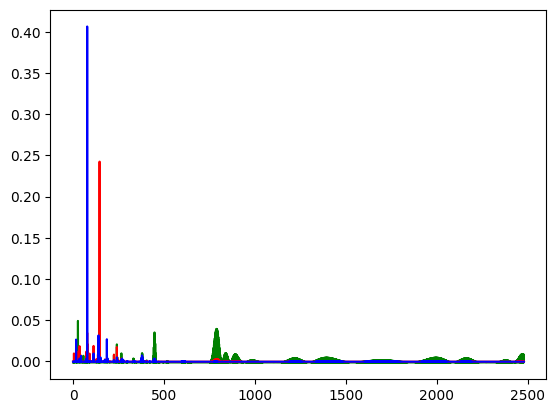

In [33]:
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_10 [0,:], color = 'green')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_10 [1,:], color = 'red')
plt.plot(range(muestra_filt.shape[0]), RS_cuantico_eeg_10 [2,:], color = 'blue')
plt.show()

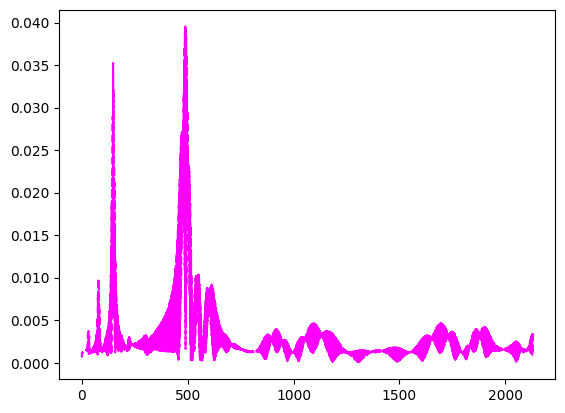

In [34]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg_10.shape[1])
input_sequence_cuant_eeg_10 = amplitude_envelope_eeg_10[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_10[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [35]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_10.T)

# Resultados
idx_10 = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_10.shape)

Centroides de los clústeres:
[[0.00181824 0.0002624  0.00030768 ... 0.00020441 0.00012314 0.00058259]
 [0.00198841 0.00033051 0.00042461 ... 0.00021516 0.00014383 0.00080116]
 [0.0050971  0.00067591 0.0006707  ... 0.0014748  0.00066125 0.00420143]
 [0.00221455 0.0005342  0.00059888 ... 0.00033692 0.00021599 0.00080731]]
(2130,)


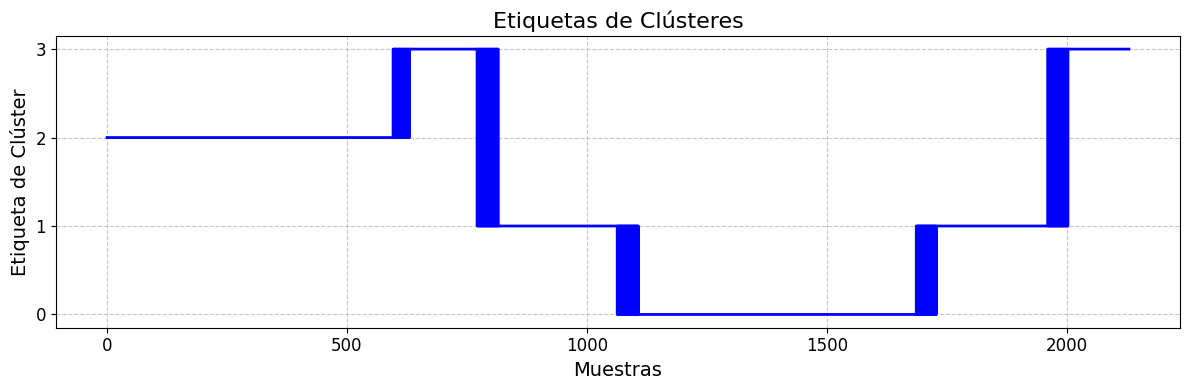

In [36]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_10.shape[1]), idx_10, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([1300,1500])
plt.tight_layout() 
plt.show()

## Implementación cuántica(sujeto mayor).

### Versión adaptada a 2 qubits por canal.

In [37]:
# Definir parámetros principales
num_qubits = 2  # hacemos uso de 2 qubits
num_channels = 65  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits))

In [38]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = muestra_filt_adult
time_steps = input_series.shape[0]

shape_qubits = 4

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [0.02632135 0.57691645 0.29468575 0.01215359]
Step 1: [0.01276336 0.46371831 0.44075547 0.01202947]
Step 2: [0.48985043 0.29248647 0.05854273 0.10386758]
Step 3: [0.00067858 0.00147804 0.59403159 0.30404463]
Step 4: [1.90294863e-03 7.34973106e-01 5.84538560e-02 1.18538325e-04]
Step 5: [0.08194146 0.55131932 0.25691622 0.03478171]
Step 6: [0.30456982 0.06852642 0.11003411 0.46708513]
Step 7: [0.16912524 0.14494289 0.30487698 0.35256996]
Step 8: [0.03780261 0.19686234 0.56567931 0.12097179]
Step 9: [0.72363924 0.04202449 0.00187594 0.0408091 ]
Step 10: [4.17370178e-03 7.10912461e-01 1.05902344e-01 4.99052688e-04]
Step 11: [0.01301633 0.00158116 0.10632738 0.70575289]
Step 12: [2.63534301e-04 2.81440203e-01 6.10579152e-01 6.46745752e-04]
Step 13: [0.04036096 0.15146406 0.56363647 0.16724563]
Step 14: [0.17253463 0.58228747 0.12598471 0.0331356 ]
Step 15: [0.02095585 0.72903728 0.05116864 0.00115832]
Step 16: [0.0803917  0.45856079 0.34930745 0.05922297]
Step 17: [0.00296246 0.4400

In [39]:
outputs = outputs.T
outputs.shape

(4, 620)

In [40]:
RS_cuantico_eeg_adulto_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_adulto_2.shape)

(4, 620)


In [41]:
analytic_signal = hilbert(RS_cuantico_eeg_adulto_2)
amplitude_envelope_eeg_adulto_2= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_adulto_2.shape)

(4, 620)
(4, 620)


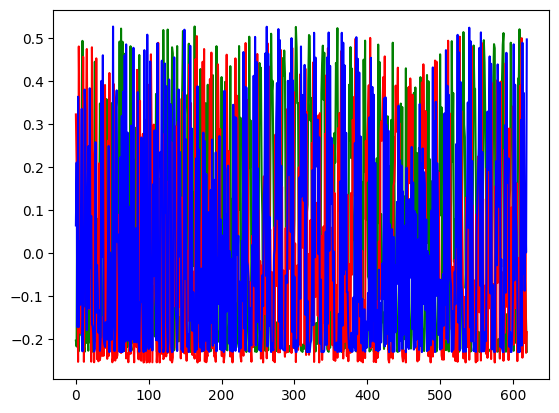

In [42]:
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_2 [0,:], color = 'green')
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_2 [1,:], color = 'red')
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_2 [2,:], color = 'blue')
plt.show()

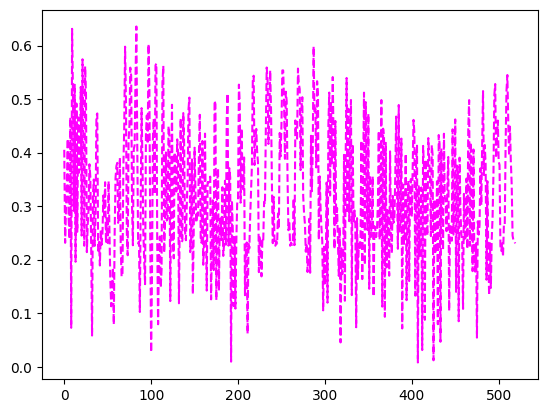

In [43]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(50, amplitude_envelope_eeg_adulto_2.shape[1])
input_sequence_cuant_eeg_adulto_2 = amplitude_envelope_eeg_adulto_2[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_adulto_2[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [44]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_adulto_2.T)

# Resultados
idx_adulto_2 = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_adulto_2.shape)

Centroides de los clústeres:
[[0.36458202 0.20307609 0.36626063 0.18584069]
 [0.17537636 0.3029405  0.1777528  0.21098235]
 [0.40980317 0.44619541 0.26075014 0.21774794]
 [0.30703696 0.32361144 0.40360253 0.43309464]]
(520,)


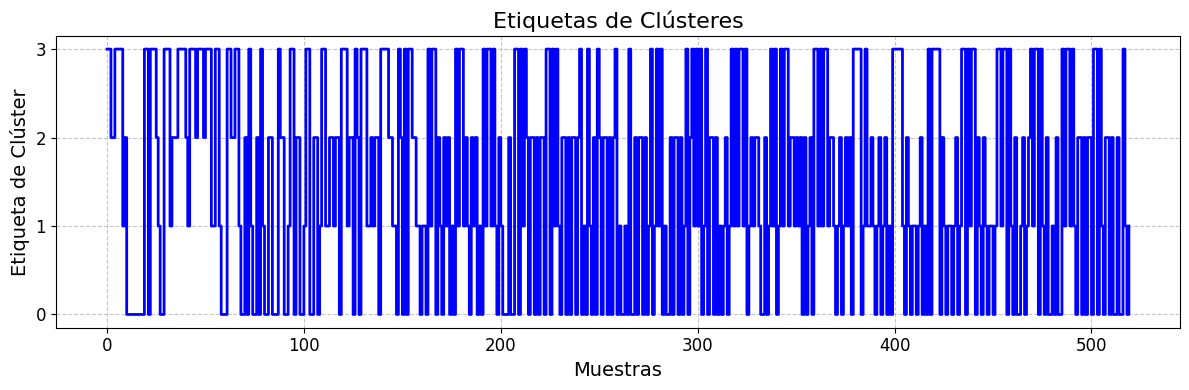

In [45]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_adulto_2.shape[1]), idx_adulto_2, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([100,200])
plt.tight_layout() 
plt.show()

### Versión adaptada a 5 qubits por canal.

In [46]:
# Definir parámetros principales
num_qubits = 5  # hacemos uso de 5 qubits
num_channels = 65  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 2 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits))

In [47]:
# Inicialización de pesos
weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Señal con múltiples canales
input_series = muestra_filt_adult
time_steps = input_series.shape[0]

shape_qubits = 32

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [3.44743306e-04 8.13947120e-03 9.64807240e-06 4.08630361e-07
 8.74505915e-04 3.70384615e-05 3.12375416e-02 6.27803263e-01
 1.61892337e-04 6.85671933e-06 5.78464560e-03 1.35738394e-01
 6.38203663e-05 1.50684606e-03 1.78609267e-06 7.56474102e-08
 1.35925050e-05 5.75691185e-07 4.85685093e-04 1.14668913e-02
 5.35836755e-06 1.26515117e-04 1.49960609e-07 6.35136793e-09
 2.89447009e-05 6.83406211e-04 8.10053608e-07 3.43086665e-08
 7.34236666e-05 3.10975479e-06 2.62355624e-03 6.18651852e-02]
Step 1: [4.57310536e-03 2.29592873e-02 1.05065683e-03 2.09237994e-04
 4.55426820e-06 9.06980831e-07 1.98231100e-05 9.95387731e-05
 5.07598010e-05 1.01087956e-05 2.20939360e-04 1.10941342e-03
 5.09260133e-02 2.50492998e-01 1.17096120e-02 2.33206727e-03
 9.37465454e-05 1.86695899e-05 4.08045354e-04 2.04893579e-03
 9.38578788e-02 4.40365822e-01 2.16237004e-02 4.30699670e-03
 8.44577042e-03 4.23847694e-02 1.94042055e-03 3.86434502e-04
 8.41112266e-06 1.67507197e-06 3.66106259e-05 1.83834765e-04]
Step 2

In [48]:
outputs = outputs.T
outputs.shape

(32, 620)

In [49]:
RS_cuantico_eeg_adulto_5 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_adulto_5.shape)

(32, 620)


In [50]:
analytic_signal = hilbert(RS_cuantico_eeg_adulto_5)
amplitude_envelope_eeg_adulto_5= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_adulto_5.shape)

(32, 620)
(32, 620)


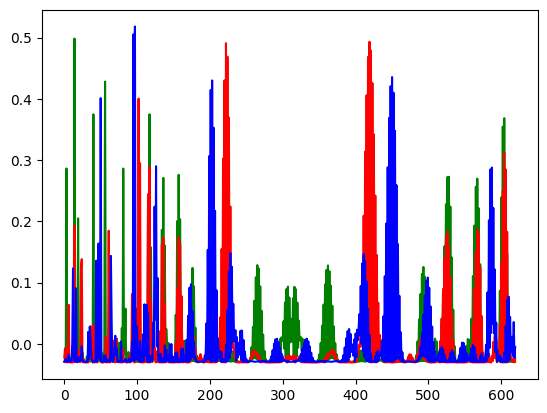

In [51]:
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_5 [0,:], color = 'green')
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_5 [1,:], color = 'red')
plt.plot(range(muestra_filt_adult.shape[0]), RS_cuantico_eeg_adulto_5 [2,:], color = 'blue')
plt.show()

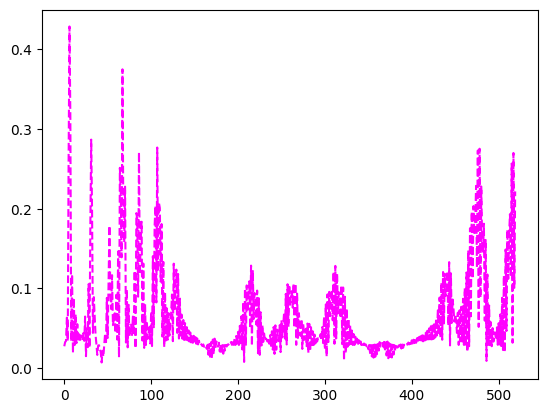

In [52]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(50, amplitude_envelope_eeg_adulto_5.shape[1])
input_sequence_cuant_eeg_adulto_5 = amplitude_envelope_eeg_adulto_5[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_adulto_5[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [53]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_adulto_5.T)

# Resultados
idx_adulto_5 = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_adulto_5.shape)

Centroides de los clústeres:
[[0.05657943 0.03357382 0.02845993 0.03290095 0.03402034 0.22807342
  0.17193524 0.03817839 0.0347307  0.03027154 0.03730975 0.03976986
  0.08455288 0.03645799 0.12967389 0.18280992 0.03621107 0.05668252
  0.04682896 0.05183681 0.08051692 0.04752976 0.05959285 0.06808406
  0.10415385 0.03016837 0.03163874 0.06046015 0.03848317 0.23190014
  0.09818131 0.03010846]
 [0.06109835 0.05567172 0.09185067 0.08433979 0.09457839 0.04397388
  0.04922001 0.09040062 0.09923048 0.05113653 0.04972643 0.10062192
  0.09911873 0.07313363 0.07895281 0.05099775 0.08760227 0.04514653
  0.05117517 0.07707435 0.06170707 0.11831027 0.12055928 0.06911778
  0.06124632 0.05041256 0.07744318 0.06440769 0.11327062 0.0520753
  0.06248792 0.07407559]
 [0.04047269 0.21682074 0.08275306 0.04538252 0.06851132 0.04653109
  0.05135213 0.07466029 0.06475086 0.04680645 0.0436162  0.07927598
  0.04184723 0.20694486 0.03681472 0.03883642 0.04819014 0.03240896
  0.0507327  0.06596083 0.03450734 0.1

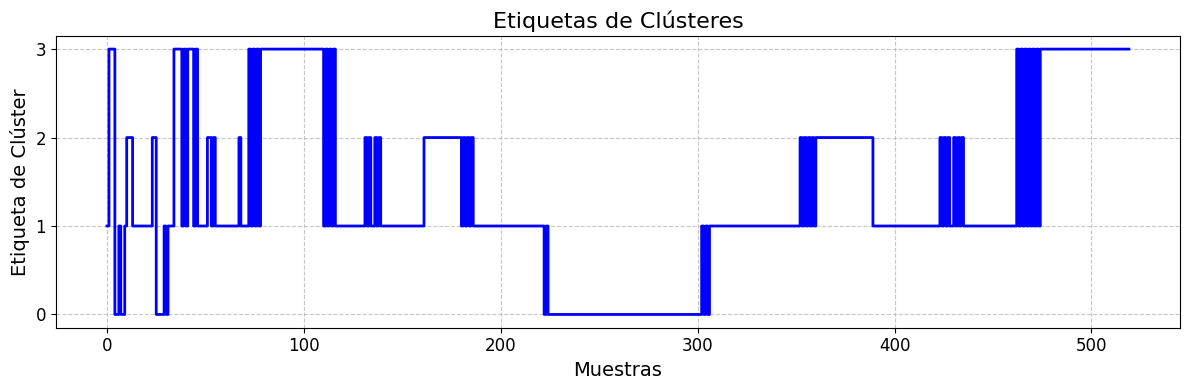

In [54]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_adulto_5.shape[1]), idx_adulto_5, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([100,200])
plt.tight_layout() 
plt.show()